In [1]:
import sys
import numpy as np
from numpy.testing import assert_almost_equal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter
from IPython import display
import copy
import pickle
# from copy import deepcopy

import argparse
from argparse import ArgumentParser

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# sys.path.append('/Users/chenwei/Desktop/Github/RPE/GSAE_source/GSAE/gsae/data_processing/')
from gsae.models.gsae_model import GSAE
from gsae.data_processing.utils import dot2adj
from gsae.data_processing.create_splits import split_data

from gsae.scattering.scattering import transform_dataset, get_normalized_moments
from gsae.utils import eval_metrics

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import phate


In [2]:
# load dataset generated by Multistrand
def loadtrj(f,FINAL_STRUCTURE,type):
    """load text data and split it into individual trajectory 
    with seperated structure, time, and energy

    Args:
        f: text file with trajectory dp notation, time, energy
            eg. '..((((....)))).', 't=0.000000103', 'seconds, dG=  0.26 kcal/mol\n'
        FINAL_STRUCTURE: final state structure, eg. "..((((....))))."
        type: 'Single' or 'Multiple' mode
    Returns:
        [list]: dot-parenthesis notation, time floats, energy floats
            eg. ['...............', 0.0, 0.0]
    """
    TRAJ=[];i=0;SIM=[]
    for s in f:
        i+=1
        if i>1: # remove headers
            ss = s.split(" ",3)
            s_dotparan=ss[0] # dp notation
            s_time = float(ss[1].split("=",1)[1]) # simulation time
            s_energy = float(ss[3].split("=")[1].split("kcal")[0]) # energy
            TRAJ.append([s_dotparan,s_time,s_energy])

            if type == "Single":
                if s_dotparan == FINAL_STRUCTURE: # split to individual trajectory
                    SIM.append(TRAJ)
                    TRAJ = []
    if type == "Multiple":
        SIM = TRAJ
    return SIM

In [3]:
# convert concantenate two individual structures to one structure
def concat_helix_structures(SIM):
    """concatenate two individual structures to one structure
    Args:
        SIM: list of individual structures
    Returns:
        SIM_concat: concatenated structure
    """
    SIM_concat = copy.deepcopy(SIM)
    for i in range(len(SIM)):
        if i == 0:
            SIM_concat[i][0] *=2 
        else:
            SIM_concat[i][0] = SIM[i][0].replace("+","")
    return SIM_concat

In [4]:
# convert dot-parenthesis notation to adjacency matrix in a single trajectory
def sim_adj(sim,helix=False):
    """convert dot-parenthesis notation to adjacency matrix in a single trajectory
    Args:
        sim: [list of sims] dot-parenthesis notation, time floats, energy floats
            eg. [['...............', 0.0, 0.0], ...]
    Returns:
        (tuple): NxN adjacency np matrix, Nx1 energy np array, Nx1 time np array, Nx1 HT np array
    """
    
    adj_mtr = []
    sim_G = np.array([])
    sim_T = np.array([])
    
    for s in sim:
        sim_T = np.append(sim_T,s[1]) # get time array
        sim_G = np.append(sim_G,s[2]) # get energy array
        
        adj = dot2adj(s[0])
        adj_mtr.append(adj)
    adj_mtr = np.array(adj_mtr) # get adjacency matrix
    
    sim_HT = np.concatenate([np.diff(sim_T),[0]])
    
    return adj_mtr,sim_G,sim_T,sim_HT


# convert all simulations
def get_whole_data(SIM):
    SIMS_adj=[]; SIMS_G=[]; SIMS_T=[]; SIMS_HT=[]
    for i in range(len(SIM)):
        data = SIM[i]
        SIM_adj,SIM_G,SIM_T,SIM_HT = sim_adj(data)
        assert min(SIM_G) == SIM_G[-1], "Final state is not the minimum energy state."
        SIMS_adj.append(SIM_adj); SIMS_T.append(SIM_T); SIMS_G.append(SIM_G); SIMS_HT.append(SIM_HT)

    SIMS_adj = np.concatenate((SIMS_adj),axis=0)
    SIMS_G = np.concatenate((SIMS_G),axis=0)
    SIMS_T = np.concatenate((SIMS_T),axis=0)
    SIMS_HT = np.concatenate((SIMS_HT),axis=0)
    
    return SIMS_adj,SIMS_G,SIMS_T,SIMS_HT

# get unique structures
def get_unique(SIM_concat,SIM_adj,SIM_G,SIM_T,SIM_HT):
    """
    # get unique states adjacency matrix with their occupancy density
    # get unique energy, and time
    """
    indices, occ_density = uniq_adj_occp(np.array(SIM_concat)[:,0])

    SIM_adj_uniq = SIM_adj[indices]
    SIM_G_uniq = SIM_G[indices]
    SIM_T_uniq = SIM_T[indices]
    SIM_HT_uniq = SIM_HT[indices]
    
    return indices,occ_density,SIM_adj_uniq,SIM_G_uniq,SIM_T_uniq,SIM_HT_uniq

In [5]:
# calulate the occupancy density of each state
def uniq_adj_occp(states):
    """load adjacency matrix and calculate the occupancy density of each state
    Args:
        states: adjacency matrix
    Returns:
        indices,density: indices of unique states, occupancy density of each state
    """
    _, indices, counts = np.unique(states,axis=0,return_index=True,return_counts=True)
    counts = counts[np.argsort(indices)]
    indices = np.sort(indices)
    return indices, counts/counts.sum()

In [6]:
def label_structures(SIM_concat):
    """label the visited states of the trajectory 
            based on their unique structure indices
    Args:
        SIM_concat: fully concatenated states of the trajectory
    Returns:
        SIM_dict: fully labeled cstates of the trajectory
    """
    # add a nan column to full states array
    new_col = np.empty(len(np.array(SIM_concat)))
    new_col.fill(np.nan)
    SIM_dict = np.c_[np.array(SIM_concat),new_col]
    # get unique structures
    SIM_dict_uniq = SIM_dict[indices]
    # label the states with its corresponding unique structure indices
    for i in range(len(SIM_dict_uniq)):
        temp = SIM_dict[:,0] == SIM_dict_uniq[i,0]
        indx = np.argwhere(temp==True)
        SIM_dict[indx,3] = i

    return SIM_dict

In [7]:
# calulate the time fraction of each state
def time_frac(SIM_adj,SIM_adj_uniq,SIM_HT):
    """load time array and calculate the time fraction of each state
    Args:
        SIM_adj,SIM_adj_uniq,SIM_HT
    Returns:
        time fractions: time fraction of each unique state
    """
    time_count = np.zeros(len(SIM_adj_uniq))
    
    for i in range(len(SIM_adj_uniq)):
        for j in range(len(SIM_adj)):
            if np.array_equal(SIM_adj_uniq[i],SIM_adj[j]):
                time_count[i] += SIM_HT[j]  
                
    time_fract = time_count/time_count.sum()
    
    # assert time_count.sum() == SIM_HT.sum(), "Time counts are not equal to total time."
    # assert time_fract.sum() == 1, "Total time fraction is not equal to 1."

    assert_almost_equal(time_count.sum(),SIM_HT.sum(),err_msg='Time counts are not equal to total time.')
    assert_almost_equal(time_fract.sum(),1,err_msg='Total time fraction is not equal to 1.')

    return time_count, time_fract

In [8]:
# load training and test data
def load_trte(train_data,test_data,
              batch_size=32,gnn=False,subsize=None,lognorm=False):

    train_adjs = train_data[0]
    train_coeffs = train_data[1]
    train_energies = train_data[2]
    
    test_adjs = test_data[0]
    test_coeffs = test_data[1]
    test_energies = test_data[2]

    if lognorm:
        # shift
        train_coeffs +=  np.abs(train_coeffs.min()) + 1
        test_coeffs += np.abs(train_coeffs.min()) + 1
        
        # log
        train_coeffs = np.log(train_coeffs)
        test_coeffs = np.log(test_coeffs)


    if gnn:
        train_diracs = torch.eye(train_adjs.shape[-1]).unsqueeze(0).repeat(train_adjs.shape[0],1,1)
        train_tup = (torch.Tensor(train_diracs),
                    torch.Tensor(train_adjs),
                    torch.Tensor(train_energies))
    else:
        train_tup = (torch.Tensor(train_coeffs),
                    torch.Tensor(train_energies))



    if gnn:
        test_diracs = torch.eye(test_adjs.shape[-1]).unsqueeze(0).repeat(test_adjs.shape[0],1,1)
        test_tup = (torch.Tensor(test_diracs),
                    torch.Tensor(test_adjs),
                    torch.Tensor(test_energies))

    else:
        test_tup = (torch.Tensor(test_coeffs), 
                    torch.Tensor(test_adjs), 
                    torch.Tensor(test_energies))
        
    #################
    # SUBSET DATA 
    #################tre
    if subsize != None:
        train_tup, _ = eval_metrics.compute_subsample(train_tup, subsize)
        test_tup, _ = eval_metrics.compute_subsample(test_tup, subsize)


    train_dataset = torch.utils.data.TensorDataset(*train_tup)
    test_dataset = torch.utils.data.TensorDataset(*test_tup)
    
    # get valid set
    train_full_size = len(train_dataset)
    train_split_size = int(train_full_size * .80)
    valid_split_size = train_full_size - train_split_size 
    train_set, val_set = torch.utils.data.random_split(train_dataset, [train_split_size, valid_split_size])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True)

    # valid loader 
    valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                        shuffle=False)
    
 
    # early stopping 
    early_stop_callback = EarlyStopping(
            monitor='val_loss',
            min_delta=0.00,
            patience=3,
            verbose=True,
            mode='min'
            )
    
    return train_loader, train_tup, test_tup, valid_loader,early_stop_callback


## 1. Import/generate Data

### 1. Load simulated data from Mulistrand

In [10]:
# load text file
# f = open('./data/helix_asso/assos_PT3_1sim_20C_21.txt', 'r') # PT3 
f = open('./data/helix_assos/assos_PT0_1sim_20C_51.txt', 'r') # PT0

""" Dimenstions of SIM list 
SIM: [[sim1], [sim2], ...]
sim: [[state1], [state2], ...]
state: [structure, time, energy]
"""
# define absorbing (final) state structure
FINAL_STRUCTURE = "(((((((((((((((((((((((((+)))))))))))))))))))))))))"


SIM = loadtrj(f,FINAL_STRUCTURE,type="Multiple")
SIM_retrieve = np.array(SIM)

print("SIM: ", len(SIM))
print("SIM_retrieve: ", SIM_retrieve.shape)

SIM_concat = concat_helix_structures(SIM) 
print("SIM_concat: ", len(SIM_concat))

SIM:  396
SIM_retrieve:  (396, 3)
SIM_concat:  396


In [11]:
SIM_concat = concat_helix_structures(SIM) 
len(SIM_concat)

396

### 2. Convert dot-paren to adjacency matrix

In [12]:
""" Dimenstions of SIM_adj list 
SIM_adj: N*m*m
    N: number of states in the trajectory
    m: number of nucleotides in the state (strand)
"""

SIM_adj,SIM_G,SIM_T,SIM_HT = sim_adj(SIM_concat)

In [13]:
SIM_adj.shape,SIM_G.shape,SIM_T.shape,SIM_HT.shape

((396, 50, 50), (396,), (396,), (396,))

In [14]:
# get unique states adjacency matrix with their occupancy density
# get unique energy, and time;
# and their corresponding indices

indices,occ_density,SIM_adj_uniq,SIM_G_uniq,SIM_T_uniq,SIM_HT_uniq \
     = get_unique(SIM_concat,SIM_adj,SIM_G,SIM_T,SIM_HT)

SIM_adj_uniq.shape,SIM_G_uniq.shape,SIM_T_uniq.shape,SIM_HT_uniq.shape

((255, 50, 50), (255,), (255,), (255,))

In [68]:
# get trajectory data with its corresponding labels 
SIM_dict = label_structures(SIM_concat) 
coord_id = SIM_dict[:,3].astype(int)
SIM_dict.shape, coord_id.shape

((396, 4), (396,))

In [16]:
# find the structure having the largest occupancy density
SIM_retrieve[indices[occ_density.argmax()]]

array(['.......(.((((...))..))...+......................)..', '4.03e-07',
       '-0.96'], dtype='<U51')

### 4. Convert adjacency matrix scattering coefficients

In [17]:
# convert all states
scat_coeff_array = transform_dataset(SIM_adj)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar = norm_scat_coeffs
SIM_scar.shape

100%|██████████| 396/396 [00:00<00:00, 2616.12it/s]


(396, 4000)

In [18]:
# convert only unique states to get unique scattering
scat_coeff_array = transform_dataset(SIM_adj_uniq)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar_uniq = norm_scat_coeffs
SIM_scar_uniq.shape

100%|██████████| 255/255 [00:00<00:00, 2915.52it/s]


(255, 4000)

In [19]:
""" Save some obtained arrays to npy file
"""
# save GSAE embeded data
with open('data/helix_assos/assos_PT0_1sim_20C_trte_uniq.npy', 'wb') as f:
    np.savez(f,SIM_adj_uniq=SIM_adj_uniq,SIM_scar_uniq=SIM_scar_uniq,
             SIM_G_uniq=SIM_G_uniq,SIM_HT_uniq=SIM_HT_uniq)

# load saved data for train/test split
npyfileT = np.load("data/helix_assos/assos_PT0_1sim_20C_trte_uniq.npy")

SIM_adj_uniq = npyfileT["SIM_adj_uniq"]
SIM_scar_uniq = npyfileT["SIM_scar_uniq"]
SIM_G_uniq = npyfileT["SIM_G_uniq"]
SIM_HT_uniq = npyfileT["SIM_HT_uniq"]
npyfileT.files

['SIM_adj_uniq', 'SIM_scar_uniq', 'SIM_G_uniq', 'SIM_HT_uniq']

### 5. Split data into tranning and test sets

In [20]:
"""Shape of split data
    train_data: [tr_adjs, tr_coeffs, tr_energies]
    test_data: [te_adjs, te_coeffs, te_energies]
"""
train_data,test_data = split_data(SIM_adj_uniq,SIM_scar_uniq,SIM_G_uniq)

In [21]:
(np.unique(train_data[1],axis=0)).shape, train_data[1].shape,test_data[1].shape

((178, 4000), (178, 4000), (77, 4000))

### 6. Train loader

In [22]:
"""Structure of train_tup when gnn=False
    train_tup: [train_coeffs,train_energy] 
"""
train_loader, train_tup, test_tup, valid_loader,early_stop_callback = load_trte(train_data,test_data,
                                              batch_size=16)
train_tup[0].shape, test_tup[0].shape, train_loader.batch_size

(torch.Size([178, 4000]), torch.Size([77, 4000]), 16)

## 2. Load Model

In [24]:
# set up hyperparameters

input_dim = train_tup[0].shape[-1]
len_epoch = len(train_loader)

hparams = {
    'input_dim':  input_dim,
    'bottle_dim': 25,
    'hidden_dim': 400,
    
    'len_epoch': len_epoch,
    'learning_rate': 0.0001,
    'max_epochs': 80,
    'n_gpus': 0,
    # 'batch_size': 32,
    
    'alpha':1.0,
    'beta':0.0001,

}

In [25]:
hparams = argparse.Namespace(**hparams)

In [26]:
hparams.len_epoch,hparams.max_epochs

(12, 80)

In [27]:
model = GSAE(hparams)

In [28]:
print(model)

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)


## 3. Train Model

In [29]:
trainer = pl.Trainer.from_argparse_args(hparams,
                                        max_epochs=hparams.max_epochs,
                                        gpus=hparams.n_gpus,
                                        # callbacks=[early_stop_callback],
                                        )
trainer.fit(model=model,
            train_dataloader=train_loader,
            val_dataloaders=valid_loader,)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type        | Params
---------------------------------------
0 | fc11   | Linear      | 1 M   
1 | bn11   | BatchNorm1d | 800   
2 | fc12   | Linear      | 160 K 
3 | bn12   | BatchNorm1d | 800   
4 | fc21   | Linear      | 10 K  
5 | fc22   | Linear      | 10 K  
6 | fc3    | Linear      | 10 K  
7 | fc4    | Linear      | 1 M   
8 | regfc1 | Linear      | 520   
9 | regfc2 | Linear      | 21    


Epoch 0:  67%|██████▋   | 10/15 [00:00<00:00, 62.53it/s, loss=64.634, v_num=100]

/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch

Epoch 79: 100%|██████████| 15/15 [00:00<00:00, 75.56it/s, loss=6.301, v_num=100] 


1

In [30]:
model

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)

In [32]:
# save the trained model
# from data I1_10000sim.txt SIM[1]
filename = "models/assos_PT0_1sim_20C_model_{}epoch.pickle".format(hparams.max_epochs)
pickle.dump(model, open(filename, 'wb'))
print('Trained model saved.')

Trained model saved.


## 3. Load Pretrained Models

In [33]:
# filename = "/Users/chenwei/Desktop/Github/GSAE/saved_models/GSAE_trained_model_seq3"
filename = "/Users/chenwei/Desktop/Github/RPE/code/models/assos_PT0_1sim_20C_model_80epoch.pickle"
model = pickle.load(open(filename, 'rb'))
model

GSAE(
  (fc11): Linear(in_features=4000, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=4000, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)

## 4. Get Embeddings

In [34]:
# without duplicates
with torch.no_grad():
        data_embed = model.embed(torch.Tensor(SIM_scar_uniq))[0]

# # with duplicates
# with torch.no_grad():
#         data_tensor =  (torch.Tensor(SIM_scar),
#                         torch.Tensor(SIM_G))
#         data_embed = model.embed(data_tensor[0])[0]

# data_embed.shape

In [35]:
""" Save embeded data to npy file
"""
# save GSAE embeded data
with open('data/helix_assos/assos_PT0_1sim_20C_embed_uniq.npy', 'wb') as f:
    np.savez(f,data_embed=data_embed)

npyfile0 = np.load("data/helix_assos/assos_PT0_1sim_20C_embed_uniq.npy")
npyfile0.files
data_embed = npyfile0["data_embed"]
data_embed.shape

(255, 25)

In [431]:
# """save embeded data to h5 file
# """
# def main():
#     hf = h5py.File("data/I1_0_embed.h5", "w")
#     hf.create_dataset("data_embed", data=data_embed)
#     hf.close

# if __name__ == "__main__":
#     main()

## 5. Visualize

### 1. PCA Vis

In [36]:
pca_coords = PCA(n_components=3).fit_transform(data_embed)
pca_coords.shape

(255, 3)

In [106]:
# get all embedded states coordinates
all_coords = pca_coords[coord_id]
all_coords.shape

(396, 3)

In [108]:
""" Save plot data to npy file
"""  
# save pca coordinates, energy, time data to npy file for Julia plot
with open('data/helix_assos/assos_PT0_1sim_20C_pca.npy', 'wb') as f:
    np.savez(f,pca=pca_coords, all_coords=all_coords,
             energy=SIM_G, energy_uniq=SIM_G_uniq,
             time_HT=SIM_HT, time_HT_uniq=SIM_HT_uniq,
             SIM_scar=SIM_scar, SIM_scar_uniq=SIM_scar_uniq, 
             occp=occ_density,
            )

npyfile = np.load("data/helix_assos/assos_PT0_1sim_20C_pca.npy")
npyfile.files

['pca',
 'all_coords',
 'energy',
 'energy_uniq',
 'time_HT',
 'time_HT_uniq',
 'SIM_scar',
 'SIM_scar_uniq',
 'occp']

In [116]:
npyfile["all_coords"][:,0].shape, npyfile["pca"][:,0].shape, 

((396,), (255,))

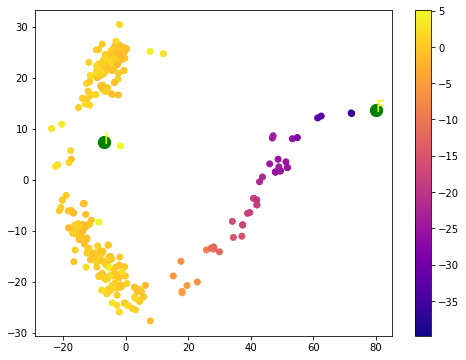

In [114]:
X = npyfile["all_coords"][:,0]
Y = npyfile["all_coords"][:,1]
Z = npyfile["all_coords"][:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=npyfile["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

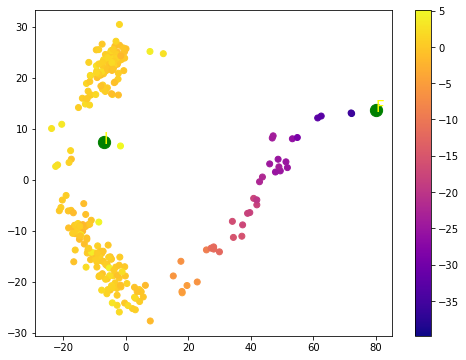

In [113]:
X = npyfile["pca"][:,0]
Y = npyfile["pca"][:,1]
Z = npyfile["pca"][:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=npyfile["energy_uniq"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

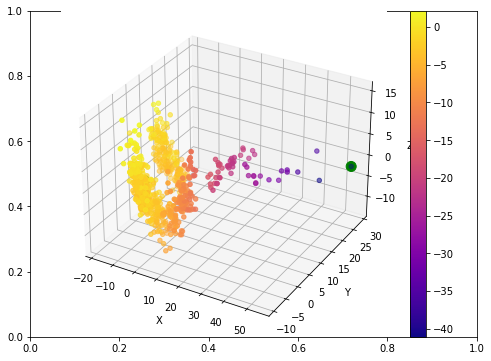

In [374]:
X = npyfile["pca"][:,0]
Y = npyfile["pca"][:,1]
Z = npyfile["pca"][:,2]

# PCA: 3 components
fig,ax = plt.subplots(figsize=(8,6))
ax = plt.axes(projection ="3d")

im = ax.scatter3D(X,Y,Z,
          c=npyfile["energy"],
          cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
z = [Z[0], Z[-1]]
ax.scatter(x,y,z,s=100,c="green",alpha=1)

#### Try use PCA directly without AE

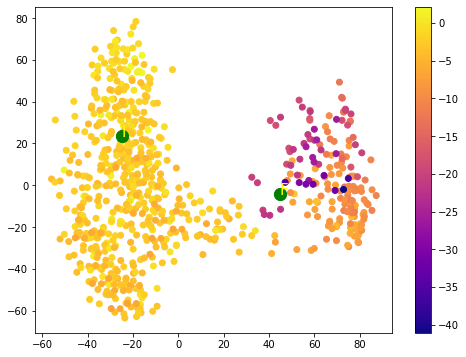

In [375]:
pca_coords1 = PCA(n_components=3).fit_transform(SIM_scar_uniq)
pca_coords1.shape

X = pca_coords1[:,0]
Y = pca_coords1[:,1]
Z = pca_coords1[:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=npyfile["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

### 2. PHATE Vis

In [309]:
npyfile0 = np.load("data/helix_asso/assos_PT3_1sim_20C_embed_uniq_1000epoch.npy")
data_embed = npyfile0["data_embed"]
data_embed.shape

(746, 25)

In [310]:
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(data_embed)
Y_phate.shape

Calculating PHATE...
  Running PHATE on 746 observations and 25 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 4.14 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 4.19 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 1.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.29 seconds.
Calculated PHATE in 5.82 seconds.


(746, 2)

In [312]:
""" Save plot data to npy file
"""  
# save pca coordinates, energy, time data to npy file for Julia plot
with open("data/helix_asso/assos_PT3_1sim_20C_phate_uniq_1000epoch.npy", 'wb') as f:
    np.savez(f,phate=Y_phate,energy=SIM_G_uniq,time_HT=SIM_HT_uniq,
             occp=occ_density,SIM_scar_uniq=SIM_scar_uniq)

npyphate = np.load("data/helix_asso/assos_PT3_1sim_20C_phate_uniq_1000epoch.npy")
Y_phate = npyphate["phate"]
Y_phate.shape, npyphate.files

((746, 2), ['phate', 'energy', 'time_HT', 'occp', 'SIM_scar_uniq'])

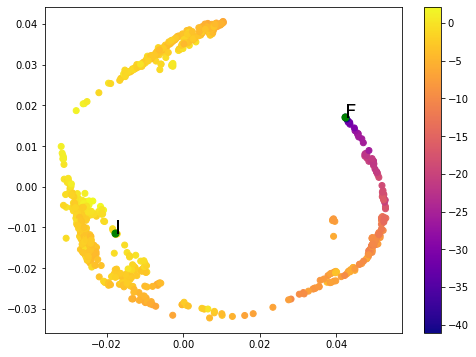

In [313]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(Y_phate[:,0],
          Y_phate[:,1],
          c=npyphate["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [Y_phate[:,0][0],Y_phate[:,0][-1]]
y = [Y_phate[:,1][0],Y_phate[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")

#### PHATE without AE

Calculating PHATE...
  Running PHATE on 746 observations and 4000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.54 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.62 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 1.78 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.36 seconds.
Calculated PHATE in 2.94 seconds.


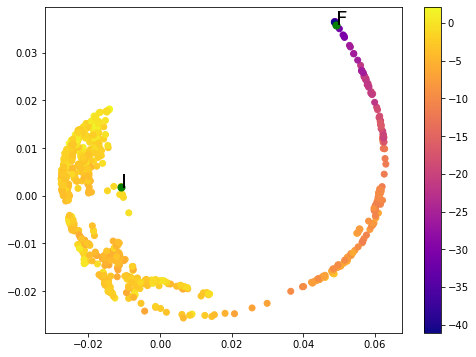

In [328]:
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(SIM_scar_uniq)
Y_phate.shape

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(Y_phate[:,0],
          Y_phate[:,1],
          c=npyphate["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [Y_phate[:,0][0],Y_phate[:,0][-1]]
y = [Y_phate[:,1][0],Y_phate[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")

### PT0 strands

#### PCA without AE

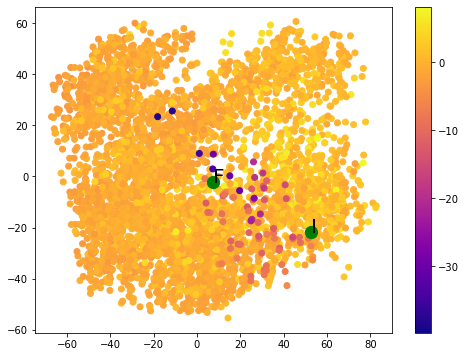

In [30]:
pca_coords = PCA(n_components=3).fit_transform(SIM_scar_uniq)

X = pca_coords[:,0]
Y = pca_coords[:,1]
Z = pca_coords[:,2]

# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=SIM_G_uniq, 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")


#### PHATE without AE

Calculating PHATE...
  Running PHATE on 4576 observations and 4000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.52 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.91 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 2.46 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.38 seconds.
    Calculating KMeans...
    Calculated KMeans in 10.42 seconds.
  Calculated landmark operator in 11.20 seconds.
  Calculating optimal t...
    Automatically selected t = 38
  Calculated optimal t in 6.50 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.44 seconds.
Calculated PHATE in 23.62 seconds.


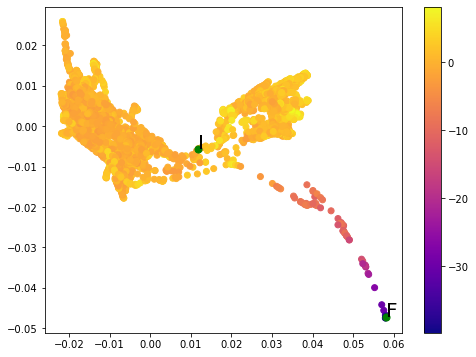

In [28]:
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(SIM_scar_uniq)
Y_phate.shape

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(Y_phate[:,0],
          Y_phate[:,1],
          # c=npyphate["energy"], 
          c = SIM_G_uniq,
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [Y_phate[:,0][0],Y_phate[:,0][-1]]
y = [Y_phate[:,1][0],Y_phate[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")

Calculating PHATE...
  Running PHATE on 9152 observations and 4000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.38 seconds.
    Calculating affinities...


/Users/chenwei/.local/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 26595 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.28 seconds.
  Calculated graph and diffusion operator in 5.69 seconds.
  Calculating landmark operator...
    Calculating SVD...


/Users/chenwei/.local/lib/python3.8/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 0.65 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.51 seconds.
  Calculated landmark operator in 15.58 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 5.10 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.49 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.36 seconds.
Calculated PHATE in 29.23 seconds.


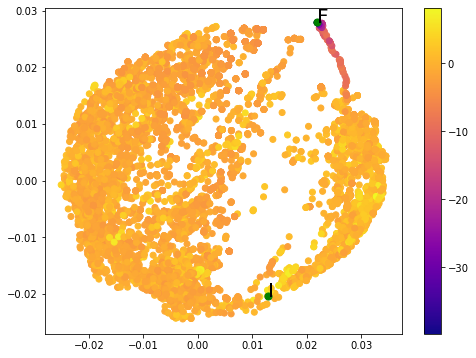

In [35]:
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(SIM_scar)
Y_phate.shape

fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(Y_phate[:,0],
          Y_phate[:,1],
          # c=npyphate["energy"], 
          c = SIM_G,
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [Y_phate[:,0][0],Y_phate[:,0][-1]]
y = [Y_phate[:,1][0],Y_phate[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")